# Fine-grained Fruits-360 Pipeline
This notebook starts from the fine-grained dataloader (1.1) and adds EDA, color-hist features, PCA exploration, and classic ML models.

In [1]:
import os
import subprocess
import shutil
import random
import json
import hashlib
from datetime import datetime
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import cv2
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor
from skimage.color import rgb2gray
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Import dataset

In [2]:
ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

GITHUB_REPO = "https://github.com/fruits-360/fruits-360-100x100"
CLONE_DIR = "dataset/fruits-360-100x100"

def download_dataset():
    os.makedirs("dataset", exist_ok=True)
    subprocess.run(["git", "clone", GITHUB_REPO, CLONE_DIR], check=True)
    os.makedirs(ROOT_DIR, exist_ok=True)
    shutil.move(os.path.join(CLONE_DIR, "Training"), TRAIN_DIR)
    shutil.move(os.path.join(CLONE_DIR, "Test"), TEST_DIR)
    shutil.rmtree(CLONE_DIR, ignore_errors=True)

if not os.path.exists(ROOT_DIR):
    download_dataset()

assert os.path.exists(TRAIN_DIR)
assert os.path.exists(TEST_DIR)

print(f"Train dir: {TRAIN_DIR}")
print(f"Test dir: {TEST_DIR}")

Train dir: dataset/fruit360/Training
Test dir: dataset/fruit360/Test


# Noise

In [3]:
import math

def clamp01(x):
    return torch.clamp(x, 0.0, 1.0)

def add_color_patches(x, num_patches, color, alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)):
    _, H, W = x.shape
    out = x.clone()
    for _ in range(num_patches):
        s = np.random.uniform(size_range[0], size_range[1])
        patch_area = s * H * W / 4
        r = np.random.uniform(0.5, 1.5)
        patch_h = int(math.sqrt(patch_area * r))
        patch_w = int(math.sqrt(patch_area / r))
        patch_h = max(1, min(H, patch_h))
        patch_w = max(1, min(W, patch_w))
        top = np.random.randint(0, H - patch_h + 1)
        left = np.random.randint(0, W - patch_w + 1)
        bottom = top + patch_h
        right = left + patch_w
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        patch = out[:, top:bottom, left:right]
        blended = alpha * color + (1 - alpha) * patch
        out[:, top:bottom, left:right] = blended
    return clamp01(out)

def add_occlusion_patch(x, area_ratio=0.1, color=torch.tensor([0.5, 0.5, 0.5]).view(3,1,1), alpha=0.5):
    _, H, W = x.shape
    out = x.clone()
    patch_area = area_ratio * H * W
    r = np.random.uniform(0.5, 1.5)
    patch_h = int(math.sqrt(patch_area * r))
    patch_w = int(math.sqrt(patch_area / r))
    patch_h = max(1, min(H, patch_h))
    patch_w = max(1, min(W, patch_w))
    top = np.random.randint(0, H - patch_h + 1)
    left = np.random.randint(0, W - patch_w + 1)
    bottom = top + patch_h
    right = left + patch_w
    patch = out[:, top:bottom, left:right]
    blended = alpha * color + (1 - alpha) * patch
    out[:, top:bottom, left:right] = blended
    return clamp01(out)

# Color definitions
color_dirt = torch.tensor([0.3, 0.25, 0.2]).view(3,1,1)
color_bruise = torch.tensor([0.25, 0.2, 0.15]).view(3,1,1)

# Individual degradations
def noise_mild(x):
    return clamp01(x + torch.randn_like(x) * 0.025)

def dark_mild(x):
    return clamp01(x * 0.65)

def overexposed_mild(x):
    return clamp01(x * 1.35)

def dirty_mild(x):
    return add_color_patches(x, num_patches=2, color=color_dirt, 
                            alpha_range=(0.5, 0.8), size_range=(0.03, 0.08))

def bruised_mild(x):
    return add_color_patches(x, num_patches=1, color=color_bruise, 
                            alpha_range=(0.4, 0.7), size_range=(0.03, 0.08))

def occlusion_small(x):
    return add_occlusion_patch(x, area_ratio=0.10, alpha=0.5)

blur_medium = T.GaussianBlur(kernel_size=5, sigma=1.0)

# Scenario definitions
def scenarioA(x):
    x = blur_medium(x)
    x = noise_mild(x)
    if np.random.rand() < 0.7:
        x = dirty_mild(x)
    return x

def scenarioB(x):
    if np.random.rand() < 0.5:
        x = dark_mild(x)
    else:
        x = overexposed_mild(x)
    x = noise_mild(x)
    return x

def scenarioC(x):
    x = occlusion_small(x)
    if np.random.rand() < 0.5:
        x = bruised_mild(x)
    else:
        x = dirty_mild(x)
    return x


## Dataloader

In [4]:
class FruitFolderDataset(Dataset):
    """
    Dataset to load and preprocess the fruit images from folder structure.

    root_dir: path to Training/ or Test/
    variety:  False -> macro label (Apple, Banana, ...)
              True  -> fine-grained label (Apple Braeburn, ...)
    """
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []

        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            label_str = class_name if variety else class_name.split()[0]

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".png")):
                    self.samples.append((os.path.join(class_dir, img_name), label_str))

        self.labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(self.labels)}
        self.idx_to_label = {i: lbl for lbl, i in self.label_to_idx.items()}

        print(f"{os.path.basename(root_dir)} -> {len(self.samples)} images, {len(self.labels)} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(image)
        else:
            img = image

        label_idx = self.label_to_idx[label_str]
        return img, label_idx


class AugmentedFruitDataset(Dataset):
    """
    Wrapper che applica augmentation random durante il training.

    Args:
        base_dataset: Dataset originale (es. train_dataset_fg)
        augment_prob: Probabilità di applicare augmentation (0.0-1.0)
        max_augmentations: Numero massimo di degradazioni da applicare
        use_scenarios: Se True, usa scenari A/B/C; se False, usa degradazioni singole
        scenario_weights: Lista di pesi per scenari [A, B, C] (opzionale)
    """
    def __init__(self, base_dataset, augment_prob=0.5, max_augmentations=1, use_scenarios=False, scenario_weights=None):
        self.base_dataset = base_dataset
        self.augment_prob = augment_prob
        self.max_augmentations = max_augmentations
        self.use_scenarios = use_scenarios

        self.single_augmentations = [
            blur_medium,
            noise_mild,
            dark_mild,
            overexposed_mild,
            dirty_mild,
            bruised_mild,
            occlusion_small,
        ]

        self.scenarios = [scenarioA, scenarioB, scenarioC]
        self.scenario_weights = None
        if scenario_weights is not None:
            weights = np.array(scenario_weights, dtype=np.float32)
            if len(weights) != len(self.scenarios):
                raise ValueError("scenario_weights deve avere lunghezza 3 (A,B,C).")
            if weights.sum() <= 0:
                raise ValueError("scenario_weights deve avere somma > 0.")
            self.scenario_weights = (weights / weights.sum()).tolist()

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]

        if np.random.rand() < self.augment_prob:
            if self.use_scenarios:
                scenario_fn = np.random.choice(self.scenarios, p=self.scenario_weights)
                img = scenario_fn(img)
            else:
                n_augs = np.random.randint(1, self.max_augmentations + 1)
                for _ in range(n_augs):
                    aug_fn = random.choice(self.single_augmentations)
                    img = aug_fn(img)

        return img, label


class AugmentedDatasetWrapper(AugmentedFruitDataset):
    def __init__(self, base_dataset, **kwargs):
        super().__init__(base_dataset, **kwargs)
        source = base_dataset
        if hasattr(base_dataset, "dataset"):
            source = base_dataset.dataset
        self.label_to_idx = getattr(source, "label_to_idx", None)
        self.idx_to_label = getattr(source, "idx_to_label", None)
        self.labels = getattr(source, "labels", None)

## Vars

In [5]:
size = 32
batch = 128
RANDOM_STATE = 42

## Checkpointing helpers

In [6]:
CKPT_ROOT = Path("artifacts/checkpoints")

def _short_hash(payload):
    data = json.dumps(payload, sort_keys=True).encode("utf-8")
    return hashlib.sha1(data).hexdigest()[:8]

def make_run_id(meta):
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    return f"{ts}_{_short_hash(meta)}"

def save_checkpoint(model, scaler, meta, run_dir=None, save_meta=False):
    meta = dict(meta)
    CKPT_ROOT.mkdir(parents=True, exist_ok=True)

    run_id = make_run_id(meta)
    run_dir = Path(run_dir) if run_dir else (
        CKPT_ROOT / meta["task"] / meta["feature"] / meta["model"] / run_id
    )
    run_dir.mkdir(parents=True, exist_ok=True)

    joblib.dump(model, run_dir / "model.joblib")
    if scaler is not None:
        joblib.dump(scaler, run_dir / "scaler.joblib")
    if save_meta:
        meta["saved_at"] = datetime.now().isoformat()
        with open(run_dir / "meta.json", "w", encoding="utf-8") as f:
            json.dump(meta, f, indent=2)
    return run_dir

## 1.1 All split

In [7]:
val_transform = T.Compose([
    T.Resize((size, size)),
    T.ToTensor()
])

full_train_dataset_fg = FruitFolderDataset(TRAIN_DIR, transform=val_transform, variety=False)
test_dataset_fg = FruitFolderDataset(TEST_DIR, transform=val_transform, variety=False)

train_size_fg = int(0.7 * len(full_train_dataset_fg))
val_size_fg = len(full_train_dataset_fg) - train_size_fg

train_dataset_fg, val_dataset_fg = random_split(
    full_train_dataset_fg,
    [train_size_fg, val_size_fg],
    generator=torch.Generator().manual_seed(RANDOM_STATE)
)

aug_train_dataset_fg = AugmentedDatasetWrapper(
    train_dataset_fg,
    augment_prob=0.5,
    max_augmentations=2,
    use_scenarios=False,
 )

train_loader_fg = DataLoader(aug_train_dataset_fg, batch_size=batch, shuffle=True)
val_loader_fg = DataLoader(val_dataset_fg, batch_size=batch, shuffle=False)
test_loader_fg = DataLoader(test_dataset_fg, batch_size=batch, shuffle=False)

print("All -> Train:", len(train_dataset_fg),
      "Val:", len(val_dataset_fg),
      "Test:", len(test_dataset_fg),
      "Classes:", len(full_train_dataset_fg.label_to_idx))

Training -> 130344 images, 79 classes
Test -> 43442 images, 79 classes
All -> Train: 91240 Val: 39104 Test: 43442 Classes: 79


## Convert loaders to numpy

In [8]:
def dataloader_to_numpy(loader):
    x_list = []
    y_list = []
    for batch_x, batch_y in loader:
        if isinstance(batch_x, torch.Tensor):
            x_list.append(batch_x.detach().cpu())
        else:
            x_list.append(torch.tensor(batch_x))
        if isinstance(batch_y, torch.Tensor):
            y_list.append(batch_y.detach().cpu())
        else:
            y_list.append(torch.tensor(batch_y))
    if not x_list:
        raise ValueError("Empty loader: no samples found.")
    X = torch.cat(x_list, dim=0).numpy()
    y = torch.cat(y_list, dim=0).numpy()
    return X, y

X_train_np, y_train_np = dataloader_to_numpy(train_loader_fg)
X_val_np, y_val_np = dataloader_to_numpy(val_loader_fg)
X_test_np, y_test_np = dataloader_to_numpy(test_loader_fg)

print("Train:", X_train_np.shape, y_train_np.shape)
print("Val:", X_val_np.shape, y_val_np.shape)
print("Test:", X_test_np.shape, y_test_np.shape)

Train: (91240, 3, 32, 32) (91240,)
Val: (39104, 3, 32, 32) (39104,)
Test: (43442, 3, 32, 32) (43442,)


## EDA (folder-based)

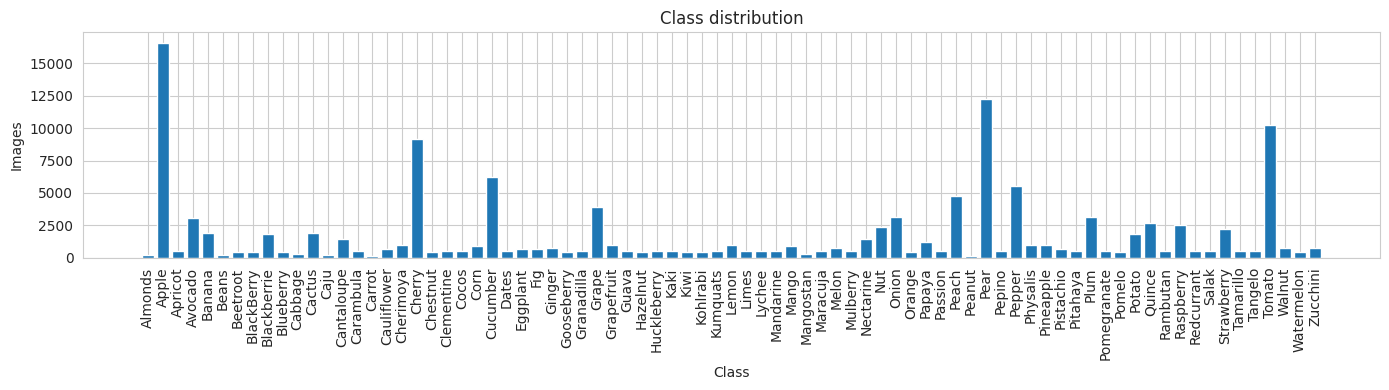

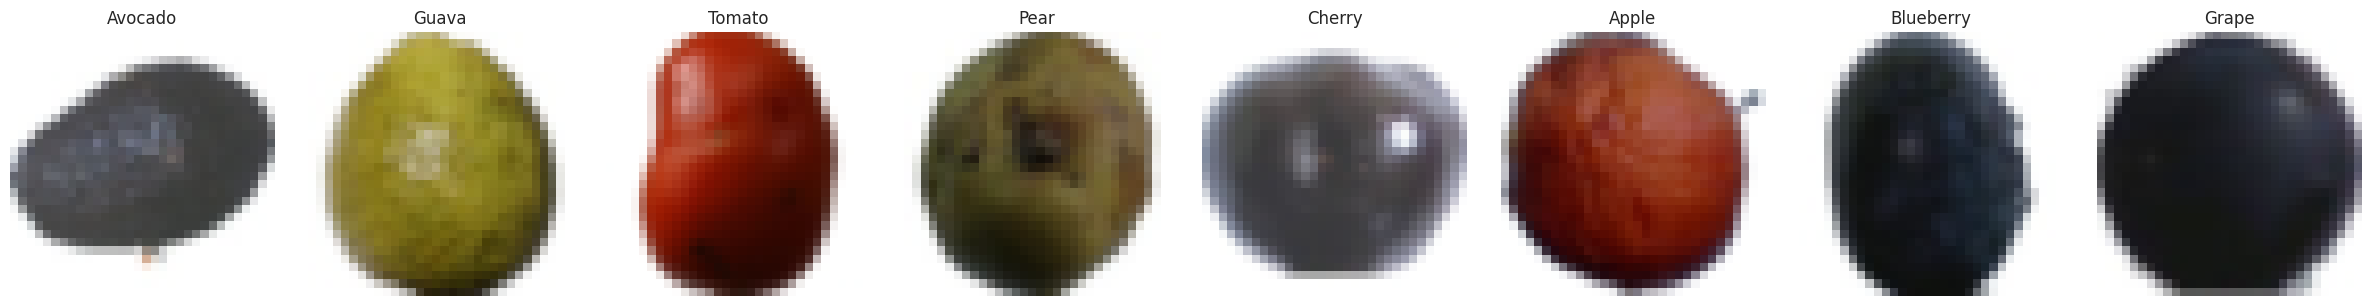

In [9]:
label_counts = {}
for _, lbl in full_train_dataset_fg.samples:
    label_counts[lbl] = label_counts.get(lbl, 0) + 1

labels_sorted = sorted(label_counts.keys())
counts_sorted = [label_counts[l] for l in labels_sorted]

plt.figure(figsize=(14, 4))
plt.bar(labels_sorted, counts_sorted)
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Random sample images
n_show = 8
indices = random.sample(range(len(train_dataset_fg)), n_show)
fig, axes = plt.subplots(1, n_show, figsize=(3*n_show, 3))
for ax, idx in zip(axes, indices):
    img, label_idx = train_dataset_fg[idx]
    img_np = img.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(full_train_dataset_fg.idx_to_label[int(label_idx)])
    ax.axis('off')
plt.tight_layout()
plt.show()

## Color histogram features

In [10]:
def color_hist_features(X, bins=16, img_shape=(3, 64, 64)):
    n_samples = X.shape[0]
    feats = np.zeros((n_samples, 3 * bins), dtype=np.float32)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    for i in range(n_samples):
        img = X[i].reshape(img_shape)
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0.0, 1.0)
        img_hsv = (img * 255.0).astype(np.uint8)
        img_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        hists = []
        for channel in (h, s, v):
            ch_norm = channel.astype(np.float32) / 255.0
            hist, _ = np.histogram(ch_norm.ravel(), bins=bin_edges, density=True)
            hists.append(hist)
        feats[i] = np.concatenate(hists)
    return feats

In [11]:
def _prepare_img(Xi, img_shape):
    img = Xi.reshape(img_shape)
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0.0, 1.0)
    return img

def _to_gray(img):
    return rgb2gray(img)

def hog_features(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    return hog(
        img_gray,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True,
    )

def lbp_features(img_gray, P=8, R=1):
    lbp = local_binary_pattern(img_gray, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), density=True)
    return hist

def glcm_features(img_gray, distances=(1, 2), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    img_u8 = np.clip(img_gray * 255.0, 0, 255).astype(np.uint8)
    glcm = graycomatrix(
        img_u8,
        distances=distances,
        angles=angles,
        levels=256,
        symmetric=True,
        normed=True,
    )
    props = ["contrast", "dissimilarity", "homogeneity", "energy", "correlation", "ASM"]
    feats = [graycoprops(glcm, p).ravel() for p in props]
    return np.concatenate(feats)

def gabor_features(img_gray, frequencies=(0.1, 0.2, 0.3), thetas=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    feats = []
    for freq in frequencies:
        for theta in thetas:
            real, imag = gabor(img_gray, frequency=freq, theta=theta)
            mag = np.sqrt(real ** 2 + imag ** 2)
            feats.append(mag.mean())
            feats.append(mag.var())
    return np.array(feats, dtype=np.float32)

def compute_feature_blocks(
    X,
    img_shape=(3, 64, 64),
    color_bins=16,
    spatial_grid=(2, 2),
    hog_params=None,
    lbp_params=None,
    glcm_params=None,
    gabor_params=None,
    feature_keys=None,
 ):
    hog_params = hog_params or {}
    lbp_params = lbp_params or {}
    glcm_params = glcm_params or {}
    gabor_params = gabor_params or {}

    if feature_keys is None:
        feature_keys = {"color_hist", "hog", "lbp", "glcm", "gabor"}
    else:
        feature_keys = set(feature_keys)

    blocks = {}
    if "color_hist" in feature_keys:
        blocks["color_hist"] = color_hist_features(X, bins=color_bins, img_shape=img_shape)

    need_gray = any(k in feature_keys for k in ("hog", "lbp", "glcm", "gabor"))
    if need_gray:
        hog_list, lbp_list, glcm_list, gabor_list = [], [], [], []
        for i in range(X.shape[0]):
            img = _prepare_img(X[i], img_shape)
            gray = _to_gray(img)
            if "hog" in feature_keys:
                hog_list.append(hog_features(gray, **hog_params))
            if "lbp" in feature_keys:
                lbp_list.append(lbp_features(gray, **lbp_params))
            if "glcm" in feature_keys:
                glcm_list.append(glcm_features(gray, **glcm_params))
            if "gabor" in feature_keys:
                gabor_list.append(gabor_features(gray, **gabor_params))
        if "hog" in feature_keys:
            blocks["hog"] = np.vstack(hog_list).astype(np.float32)
        if "lbp" in feature_keys:
            blocks["lbp"] = np.vstack(lbp_list).astype(np.float32)
        if "glcm" in feature_keys:
            blocks["glcm"] = np.vstack(glcm_list).astype(np.float32)
        if "gabor" in feature_keys:
            blocks["gabor"] = np.vstack(gabor_list).astype(np.float32)
    return blocks

def concat_feature_blocks(blocks, keys):
    return np.concatenate([blocks[k] for k in keys], axis=1)

In [12]:
COLOR_BINS = 16
SPATIAL_GRID = (2, 2)
QUICK_TEST = True  # Set to False per il run completo

## Models on feature combinations (SVM)

In [13]:
# Configurazione singola di rumore, testata su tutte le combinazioni di feature
noise_configs = [
    {"name": "noise_base", "augment_prob": 0.2, "max_augmentations": 1, "use_scenarios": True, "scenario_weights": [0.4, 0.4, 0.2]},
]

def make_train_loader(cfg):
    aug_ds = AugmentedDatasetWrapper(
        train_dataset_fg,
        augment_prob=cfg["augment_prob"],
        max_augmentations=cfg["max_augmentations"],
        use_scenarios=cfg["use_scenarios"],
        scenario_weights=cfg.get("scenario_weights"),
    )
    return DataLoader(aug_ds, batch_size=batch, shuffle=True)

val_loader = DataLoader(val_dataset_fg, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset_fg, batch_size=batch, shuffle=False)

X_val_np, y_val = dataloader_to_numpy(val_loader)
X_test_np, y_test = dataloader_to_numpy(test_loader)

feature_sets = {
    "color_hist+hog": ("color_hist", "hog"),
    "color_hist+lbp": ("color_hist", "lbp"),
    "color_hist+glcm": ("color_hist", "glcm"),
    "color_hist+gabor": ("color_hist", "gabor"),
    "color_hist+hog+lbp": ("color_hist", "hog", "lbp"),
}

feature_param_sets = [
    {
        "name": "p1",
        "hog": {"pixels_per_cell": (8, 8), "cells_per_block": (2, 2), "orientations": 9},
        "lbp": {"P": 8, "R": 1},
        "glcm": {"distances": (1, 2), "angles": (0, np.pi/4, np.pi/2, 3*np.pi/4)},
        "gabor": {"frequencies": (0.1, 0.2, 0.3), "thetas": (0, np.pi/4, np.pi/2, 3*np.pi/4)},
    },
    {
        "name": "p2",
        "hog": {"pixels_per_cell": (4, 4), "cells_per_block": (2, 2), "orientations": 9},
        "lbp": {"P": 16, "R": 2},
        "glcm": {"distances": (1, 3), "angles": (0, np.pi/2)},
        "gabor": {"frequencies": (0.2, 0.3, 0.4), "thetas": (0, np.pi/4, np.pi/2, 3*np.pi/4)},
    },
]

C_list = [10, 20, 40]

results_grid = []
model_out_root = CKPT_ROOT / "fruit360"
model_out_root.mkdir(parents=True, exist_ok=True)

### Run a single combination (manual)
Esegui una combinazione alla volta cambiando `cfg`, `param_cfg` e `feature_name` qui sotto.

In [27]:
# Scegli una combinazione
cfg = noise_configs[0]
param_cfg = feature_param_sets[0]
feature_name, keys = next(iter(feature_sets.items()))

print(f"CFG={cfg['name']} | PARAM={param_cfg['name']} | FEATURE={feature_name}")

# Train set per questa cfg
train_loader_cfg = make_train_loader(cfg)
X_train_np, y_train = dataloader_to_numpy(train_loader_cfg)

# Calcolo blocchi solo per le feature richieste
print("[VAL blocks]")
val_blocks = compute_feature_blocks(
    X_val_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )
print("[TEST blocks]")
test_blocks = compute_feature_blocks(
    X_test_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )
print("[TRAIN blocks]")
train_blocks = compute_feature_blocks(
    X_train_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )

# Estrai feature per la combinazione selezionata
X_train_feat = concat_feature_blocks(train_blocks, keys)
X_val_feat = concat_feature_blocks(val_blocks, keys)
X_test_feat = concat_feature_blocks(test_blocks, keys)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_feat)
X_val_std = scaler.transform(X_val_feat)
X_test_std = scaler.transform(X_test_feat)

meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": feature_name,
    "feature_keys": keys,
    "feature_param_set": param_cfg["name"],
    "feature_params": param_cfg,
    "img_size": size,
    "bins": COLOR_BINS,
    "spatial_grid": SPATIAL_GRID,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
    "noise_cfg": cfg,
}

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", gamma="scale", C=C)
    svm.fit(X_train_std, y_train)
    y_val_pred = svm.predict(X_val_std)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
        print(f"  [SVM] new best C={best_C} val_acc={best_svm_acc:.4f}")
if best_svm_model is not None:
    y_test_pred = best_svm_model.predict(X_test_std)
    test_acc = accuracy_score(y_test, y_test_pred)
    run_dir = model_out_root / cfg["name"] / param_cfg["name"] / feature_name / "svm"
    save_checkpoint(
        best_svm_model,
        scaler,
        {**meta_base, "model": f"svm-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
        run_dir=run_dir,
        save_meta=False,
    )
    results_grid.append({"cfg": cfg["name"], "param": param_cfg["name"], "feature": feature_name, "model": "svm", "val_acc": best_svm_acc, "test_acc": test_acc})

results_df = pd.DataFrame(results_grid)
if not results_df.empty:
    results_df = results_df.sort_values(["test_acc", "val_acc"], ascending=False)
results_df

CFG=noise_base | PARAM=p1 | FEATURE=color_hist+hog
[VAL blocks]
[TEST blocks]
[TRAIN blocks]
  [SVM] new best C=10 val_acc=0.9999


,cfg,param,feature,model,val_acc,test_acc
0,noise_base,p1,color_hist+hog,svm,0.999872,0.968878


In [14]:
# Scegli la prossima combinazione
cfg = noise_configs[0]
param_cfg = feature_param_sets[1] if len(feature_param_sets) > 1 else feature_param_sets[0]
feature_items = list(feature_sets.items())
feature_name, keys = feature_items[1] if len(feature_items) > 1 else feature_items[0]

print(f"CFG={cfg['name']} | PARAM={param_cfg['name']} | FEATURE={feature_name}")

# Train set per questa cfg
train_loader_cfg = make_train_loader(cfg)
X_train_np, y_train = dataloader_to_numpy(train_loader_cfg)

# Calcolo blocchi solo per le feature richieste
print("[VAL blocks]")
val_blocks = compute_feature_blocks(
    X_val_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )
print("[TEST blocks]")
test_blocks = compute_feature_blocks(
    X_test_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )
print("[TRAIN blocks]")
train_blocks = compute_feature_blocks(
    X_train_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )

# Estrai feature per la combinazione selezionata
X_train_feat = concat_feature_blocks(train_blocks, keys)
X_val_feat = concat_feature_blocks(val_blocks, keys)
X_test_feat = concat_feature_blocks(test_blocks, keys)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_feat)
X_val_std = scaler.transform(X_val_feat)
X_test_std = scaler.transform(X_test_feat)

meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": feature_name,
    "feature_keys": keys,
    "feature_param_set": param_cfg["name"],
    "feature_params": param_cfg,
    "img_size": size,
    "bins": COLOR_BINS,
    "spatial_grid": SPATIAL_GRID,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
    "noise_cfg": cfg,
}

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", gamma="scale", C=C)
    svm.fit(X_train_std, y_train)
    y_val_pred = svm.predict(X_val_std)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
        print(f"  [SVM] new best C={best_C} val_acc={best_svm_acc:.4f}")
if best_svm_model is not None:
    y_test_pred = best_svm_model.predict(X_test_std)
    test_acc = accuracy_score(y_test, y_test_pred)
    run_dir = model_out_root / cfg["name"] / param_cfg["name"] / feature_name / "svm"
    save_checkpoint(
        best_svm_model,
        scaler,
        {**meta_base, "model": f"svm-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
        run_dir=run_dir,
        save_meta=False,
    )
    results_grid.append({"cfg": cfg["name"], "param": param_cfg["name"], "feature": feature_name, "model": "svm", "val_acc": best_svm_acc, "test_acc": test_acc})

results_df = pd.DataFrame(results_grid)
if not results_df.empty:
    results_df = results_df.sort_values(["test_acc", "val_acc"], ascending=False)
results_df

CFG=noise_base | PARAM=p2 | FEATURE=color_hist+lbp
[VAL blocks]


/home/leo/Documents/repo/Ml_Project/venv/lib/python3.14/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


[TEST blocks]
[TRAIN blocks]
  [SVM] new best C=10 val_acc=0.9999
  [SVM] new best C=20 val_acc=0.9999
  [SVM] new best C=40 val_acc=1.0000


,cfg,param,feature,model,val_acc,test_acc
0,noise_base,p2,color_hist+lbp,svm,0.999974,0.985728


In [15]:
# Scegli un'altra combinazione
cfg = noise_configs[0]
param_cfg = feature_param_sets[1] if len(feature_param_sets) > 1 else feature_param_sets[0]
feature_items = list(feature_sets.items())
feature_name, keys = feature_items[2] if len(feature_items) > 2 else feature_items[0]

print(f"CFG={cfg['name']} | PARAM={param_cfg['name']} | FEATURE={feature_name}")

# Train set per questa cfg
train_loader_cfg = make_train_loader(cfg)
X_train_np, y_train = dataloader_to_numpy(train_loader_cfg)

# Calcolo blocchi solo per le feature richieste
print("[VAL blocks]")
val_blocks = compute_feature_blocks(
    X_val_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )
print("[TEST blocks]")
test_blocks = compute_feature_blocks(
    X_test_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )
print("[TRAIN blocks]")
train_blocks = compute_feature_blocks(
    X_train_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )

# Estrai feature per la combinazione selezionata
X_train_feat = concat_feature_blocks(train_blocks, keys)
X_val_feat = concat_feature_blocks(val_blocks, keys)
X_test_feat = concat_feature_blocks(test_blocks, keys)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_feat)
X_val_std = scaler.transform(X_val_feat)
X_test_std = scaler.transform(X_test_feat)

meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": feature_name,
    "feature_keys": keys,
    "feature_param_set": param_cfg["name"],
    "feature_params": param_cfg,
    "img_size": size,
    "bins": COLOR_BINS,
    "spatial_grid": SPATIAL_GRID,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
    "noise_cfg": cfg,
}

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", gamma="scale", C=C)
    svm.fit(X_train_std, y_train)
    y_val_pred = svm.predict(X_val_std)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
        print(f"  [SVM] new best C={best_C} val_acc={best_svm_acc:.4f}")
if best_svm_model is not None:
    y_test_pred = best_svm_model.predict(X_test_std)
    test_acc = accuracy_score(y_test, y_test_pred)
    run_dir = model_out_root / cfg["name"] / param_cfg["name"] / feature_name / "svm"
    save_checkpoint(
        best_svm_model,
        scaler,
        {**meta_base, "model": f"svm-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
        run_dir=run_dir,
        save_meta=False,
    )
    results_grid.append({"cfg": cfg["name"], "param": param_cfg["name"], "feature": feature_name, "model": "svm", "val_acc": best_svm_acc, "test_acc": test_acc})

results_df = pd.DataFrame(results_grid)
if not results_df.empty:
    results_df = results_df.sort_values(["test_acc", "val_acc"], ascending=False)
results_df

CFG=noise_base | PARAM=p2 | FEATURE=color_hist+glcm
[VAL blocks]
[TEST blocks]
[TRAIN blocks]
  [SVM] new best C=10 val_acc=0.9998
  [SVM] new best C=20 val_acc=0.9999


,cfg,param,feature,model,val_acc,test_acc
1,noise_base,p2,color_hist+glcm,svm,0.999949,0.986557
0,noise_base,p2,color_hist+lbp,svm,0.999974,0.985728


In [ ]:
# Quarta combinazione
cfg = noise_configs[0]
param_cfg = feature_param_sets[1] if len(feature_param_sets) > 1 else feature_param_sets[0]
feature_items = list(feature_sets.items())
feature_name, keys = feature_items[3] if len(feature_items) > 3 else feature_items[0]

print(f"CFG={cfg['name']} | PARAM={param_cfg['name']} | FEATURE={feature_name}")

# Train set per questa cfg
train_loader_cfg = make_train_loader(cfg)
X_train_np, y_train = dataloader_to_numpy(train_loader_cfg)

# Calcolo blocchi solo per le feature richieste
print("[VAL blocks]")
val_blocks = compute_feature_blocks(
    X_val_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )
print("[TEST blocks]")
test_blocks = compute_feature_blocks(
    X_test_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )
print("[TRAIN blocks]")
train_blocks = compute_feature_blocks(
    X_train_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )

# Estrai feature per la combinazione selezionata
X_train_feat = concat_feature_blocks(train_blocks, keys)
X_val_feat = concat_feature_blocks(val_blocks, keys)
X_test_feat = concat_feature_blocks(test_blocks, keys)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_feat)
X_val_std = scaler.transform(X_val_feat)
X_test_std = scaler.transform(X_test_feat)

meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": feature_name,
    "feature_keys": keys,
    "feature_param_set": param_cfg["name"],
    "feature_params": param_cfg,
    "img_size": size,
    "bins": COLOR_BINS,
    "spatial_grid": SPATIAL_GRID,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
    "noise_cfg": cfg,
}

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", gamma="scale", C=C)
    svm.fit(X_train_std, y_train)
    y_val_pred = svm.predict(X_val_std)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
        print(f"  [SVM] new best C={best_C} val_acc={best_svm_acc:.4f}")
if best_svm_model is not None:
    y_test_pred = best_svm_model.predict(X_test_std)
    test_acc = accuracy_score(y_test, y_test_pred)
    run_dir = model_out_root / cfg["name"] / param_cfg["name"] / feature_name / "svm"
    save_checkpoint(
        best_svm_model,
        scaler,
        {**meta_base, "model": f"svm-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
        run_dir=run_dir,
        save_meta=False,
    )
    results_grid.append({"cfg": cfg["name"], "param": param_cfg["name"], "feature": feature_name, "model": "svm", "val_acc": best_svm_acc, "test_acc": test_acc})

results_df = pd.DataFrame(results_grid)
if not results_df.empty:
    results_df = results_df.sort_values(["test_acc", "val_acc"], ascending=False)
results_df

In [ ]:
# Quinta combinazione
cfg = noise_configs[0]
param_cfg = feature_param_sets[0] if len(feature_param_sets) > 0 else feature_param_sets[0]
feature_items = list(feature_sets.items())
feature_name, keys = feature_items[4] if len(feature_items) > 4 else feature_items[0]

print(f"CFG={cfg['name']} | PARAM={param_cfg['name']} | FEATURE={feature_name}")

# Train set per questa cfg
train_loader_cfg = make_train_loader(cfg)
X_train_np, y_train = dataloader_to_numpy(train_loader_cfg)

# Calcolo blocchi solo per le feature richieste
print("[VAL blocks]")
val_blocks = compute_feature_blocks(
    X_val_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )
print("[TEST blocks]")
test_blocks = compute_feature_blocks(
    X_test_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )
print("[TRAIN blocks]")
train_blocks = compute_feature_blocks(
    X_train_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )

# Estrai feature per la combinazione selezionata
X_train_feat = concat_feature_blocks(train_blocks, keys)
X_val_feat = concat_feature_blocks(val_blocks, keys)
X_test_feat = concat_feature_blocks(test_blocks, keys)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_feat)
X_val_std = scaler.transform(X_val_feat)
X_test_std = scaler.transform(X_test_feat)

meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": feature_name,
    "feature_keys": keys,
    "feature_param_set": param_cfg["name"],
    "feature_params": param_cfg,
    "img_size": size,
    "bins": COLOR_BINS,
    "spatial_grid": SPATIAL_GRID,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
    "noise_cfg": cfg,
}

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", gamma="scale", C=C)
    svm.fit(X_train_std, y_train)
    y_val_pred = svm.predict(X_val_std)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
        print(f"  [SVM] new best C={best_C} val_acc={best_svm_acc:.4f}")
if best_svm_model is not None:
    y_test_pred = best_svm_model.predict(X_test_std)
    test_acc = accuracy_score(y_test, y_test_pred)
    run_dir = model_out_root / cfg["name"] / param_cfg["name"] / feature_name / "svm"
    save_checkpoint(
        best_svm_model,
        scaler,
        {**meta_base, "model": f"svm-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
        run_dir=run_dir,
        save_meta=False,
    )
    results_grid.append({"cfg": cfg["name"], "param": param_cfg["name"], "feature": feature_name, "model": "svm", "val_acc": best_svm_acc, "test_acc": test_acc})

results_df = pd.DataFrame(results_grid)
if not results_df.empty:
    results_df = results_df.sort_values(["test_acc", "val_acc"], ascending=False)
results_df

In [ ]:
# Sesta combinazione
cfg = noise_configs[0]
param_cfg = feature_param_sets[0] if len(feature_param_sets) > 0 else feature_param_sets[0]
feature_items = list(feature_sets.items())
feature_name, keys = feature_items[5] if len(feature_items) > 5 else feature_items[0]

print(f"CFG={cfg['name']} | PARAM={param_cfg['name']} | FEATURE={feature_name}")

# Train set per questa cfg
train_loader_cfg = make_train_loader(cfg)
X_train_np, y_train = dataloader_to_numpy(train_loader_cfg)

# Calcolo blocchi solo per le feature richieste
print("[VAL blocks]")
val_blocks = compute_feature_blocks(
    X_val_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )
print("[TEST blocks]")
test_blocks = compute_feature_blocks(
    X_test_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )
print("[TRAIN blocks]")
train_blocks = compute_feature_blocks(
    X_train_np,
    img_shape=(3, size, size),
    color_bins=COLOR_BINS,
    spatial_grid=SPATIAL_GRID,
    hog_params=param_cfg["hog"],
    lbp_params=param_cfg["lbp"],
    glcm_params=param_cfg["glcm"],
    gabor_params=param_cfg["gabor"],
    feature_keys=keys,
 )

# Estrai feature per la combinazione selezionata
X_train_feat = concat_feature_blocks(train_blocks, keys)
X_val_feat = concat_feature_blocks(val_blocks, keys)
X_test_feat = concat_feature_blocks(test_blocks, keys)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_feat)
X_val_std = scaler.transform(X_val_feat)
X_test_std = scaler.transform(X_test_feat)

meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": feature_name,
    "feature_keys": keys,
    "feature_param_set": param_cfg["name"],
    "feature_params": param_cfg,
    "img_size": size,
    "bins": COLOR_BINS,
    "spatial_grid": SPATIAL_GRID,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
    "noise_cfg": cfg,
}

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", gamma="scale", C=C)
    svm.fit(X_train_std, y_train)
    y_val_pred = svm.predict(X_val_std)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
        print(f"  [SVM] new best C={best_C} val_acc={best_svm_acc:.4f}")
if best_svm_model is not None:
    y_test_pred = best_svm_model.predict(X_test_std)
    test_acc = accuracy_score(y_test, y_test_pred)
    run_dir = model_out_root / cfg["name"] / param_cfg["name"] / feature_name / "svm"
    save_checkpoint(
        best_svm_model,
        scaler,
        {**meta_base, "model": f"svm-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
        run_dir=run_dir,
        save_meta=False,
    )
    results_grid.append({"cfg": cfg["name"], "param": param_cfg["name"], "feature": feature_name, "model": "svm", "val_acc": best_svm_acc, "test_acc": test_acc})

results_df = pd.DataFrame(results_grid)
if not results_df.empty:
    results_df = results_df.sort_values(["test_acc", "val_acc"], ascending=False)
results_df